# Анализ взаимодействия с пользователями сети фитнес-центров «Культурист-датасаентист». Прогноз вероятности оттока (на уровне следующего месяца) для каждого клиента.

***Описание проекта.***

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что пользователь больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
проанализировать основные признаки, наиболее сильно влияющие на отток;
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

- выделить целевые группы клиентов;
- предложить меры по снижению оттока;
- определить другие особенности взаимодействия с клиентами.

## Загрузим данные.

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
if os.path.exists('/datasets/gym_churn.csv'):
    gym_churn = pd.read_csv('/datasets/gym_churn.csv')
else:
    gym_churn = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Основы машинного обучения/gym_churn.csv')

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
gym_churn.head()# посмотрим на данные

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


***Описание данных***

«Культурист-датасаентист» предоставил сведения в csv-файлах. 

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:

Данные пользователя за предыдущий до проверки факта оттока месяц:
- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

In [5]:
round((gym_churn.isnull().mean()*100),2) # проверим на 0

gender                               0.0
Near_Location                        0.0
Partner                              0.0
Promo_friends                        0.0
Phone                                0.0
Contract_period                      0.0
Group_visits                         0.0
Age                                  0.0
Avg_additional_charges_total         0.0
Month_to_end_contract                0.0
Lifetime                             0.0
Avg_class_frequency_total            0.0
Avg_class_frequency_current_month    0.0
Churn                                0.0
dtype: float64

In [6]:
round((gym_churn.isna().mean()*100),2) # проверим на пропуски

gender                               0.0
Near_Location                        0.0
Partner                              0.0
Promo_friends                        0.0
Phone                                0.0
Contract_period                      0.0
Group_visits                         0.0
Age                                  0.0
Avg_additional_charges_total         0.0
Month_to_end_contract                0.0
Lifetime                             0.0
Avg_class_frequency_total            0.0
Avg_class_frequency_current_month    0.0
Churn                                0.0
dtype: float64

In [7]:
gym_churn.columns = gym_churn.columns.str.lower() # переведём название столбцов в нижний регистр

In [8]:
gym_churn.duplicated().sum() # проверим на дубликаты

0

In [9]:
gym_churn.info() # посмотрим типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [10]:
gym_churn.describe().T # посмотрим на средние значения и std

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [11]:
gym_churn.shape

(4000, 14)

В ходе загрузки и первой проверки данных выяснилось, что они не содержат пропусков, нолей и дубликатов.
Для удобства были переименованы солбцы.
К исследованию доступно 4000 строк, 14 столбцов.
Типы данных - целые и вещественные числа.
Категориальные данные в столбцах 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits' и 'churn' преобразованны в числовые значения 0 и 1.

Если посмотреть на средние значения признаков, то можно сказать что:

- распределение абонентов по гендерному признаку почти 50/50;
- большая чать абонентов живёт или работает в районе, где находится фитнес-центр и является сотрудником компании-партнёра клуба;
- около 30% абонентов пришли в рамках акции «приведи друга»;
- около 40% - посещают групповые занятия;
- длительность текущего действующего абонемента: из четырёх вариантов (месяц, 3 месяца, 6 месяцев, год), клиенты предпочитают месяц. Медиана равна 1, при среднем 4.68 и std 4.55. 

# Исследовательский анализ данных.

## Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [12]:
# разделим на два df и посмотрим на средние значения признаков
churn = gym_churn.query('churn == 1')
print('Данные по клиентам, которые попали в отток.')
display(churn.describe().T)
remain = gym_churn.query('churn == 0')
print('Данные по оставшимся клиентам.')
display(remain.describe().T)

Данные по клиентам, которые попали в отток.


,count,mean,std,min,25%,50%,75%,max
gender,1061.0,0.510839,0.500118,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,1061.0,0.768143,0.422217,0.000000,1.000000,1.000000,1.000000,1.000000
partner,1061.0,0.355325,0.478837,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,1061.0,0.183789,0.387495,0.000000,0.000000,0.000000,0.000000,1.000000
phone,1061.0,0.902922,0.296204,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,1061.0,1.728558,2.132371,1.000000,1.000000,1.000000,1.000000,12.000000
group_visits,1061.0,0.268615,0.443448,0.000000,0.000000,0.000000,1.000000,1.000000
age,1061.0,26.989632,2.895163,18.000000,25.000000,27.000000,29.000000,38.000000
avg_additional_charges_total,1061.0,115.082899,77.696419,0.148205,50.629127,103.814686,165.616858,425.535220
month_to_end_contract,1061.0,1.662582,1.964593,1.000000,1.000000,1.000000,1.000000,12.000000


Данные по оставшимся клиентам.


,count,mean,std,min,25%,50%,75%,max
gender,2939.0,0.510037,0.499984,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,2939.0,0.873086,0.332933,0.000000,1.000000,1.000000,1.000000,1.000000
partner,2939.0,0.534195,0.498914,0.000000,0.000000,1.000000,1.000000,1.000000
promo_friends,2939.0,0.353522,0.478144,0.000000,0.000000,0.000000,1.000000,1.000000
phone,2939.0,0.903709,0.295040,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,2939.0,5.747193,4.716942,1.000000,1.000000,6.000000,12.000000,12.000000
group_visits,2939.0,0.464103,0.498795,0.000000,0.000000,0.000000,1.000000,1.000000
age,2939.0,29.976523,3.009933,19.000000,28.000000,30.000000,32.000000,41.000000
avg_additional_charges_total,2939.0,158.445715,99.801599,0.171862,76.920993,149.881171,224.448274,552.590740
month_to_end_contract,2939.0,5.283089,4.363522,1.000000,1.000000,6.000000,10.000000,12.000000


Средние значения для клиента попавшего в отток:

- lifetime 1 месяц
- contract_period 1.7 месяца
- month_to_end_contract 1.6 месяца
- age 27 лет

Теже признаки для оставшегося клиента:

- lifetime 5 месяцев
- contract_period 5.7 месяца
- month_to_end_contract 5.2 месяца
- age 30 лет

Достаточно очевидная разница.

## Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

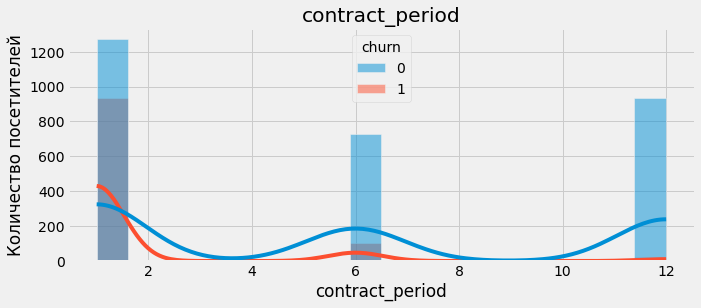

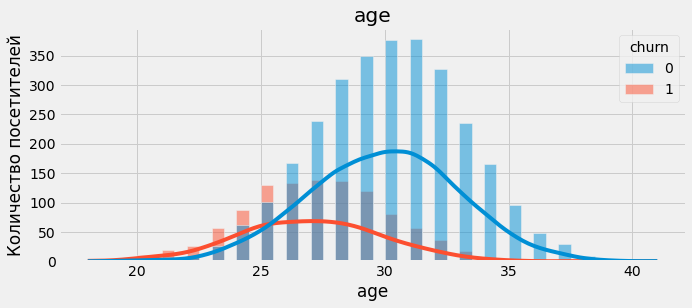

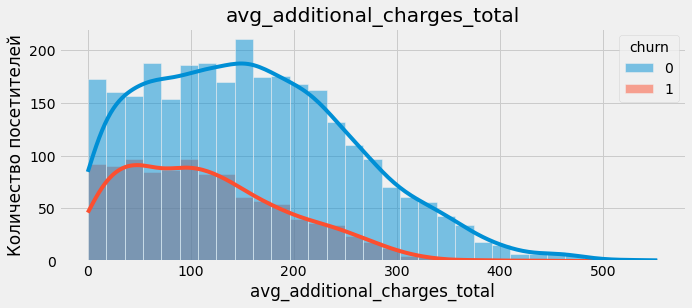

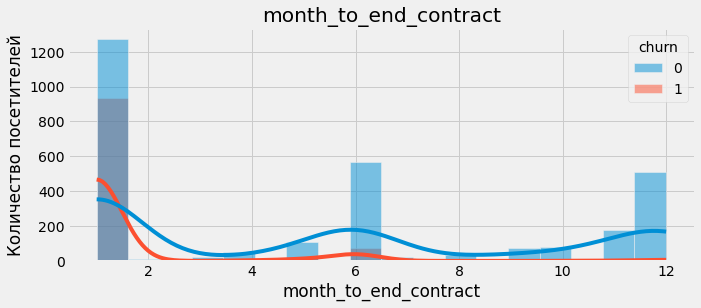

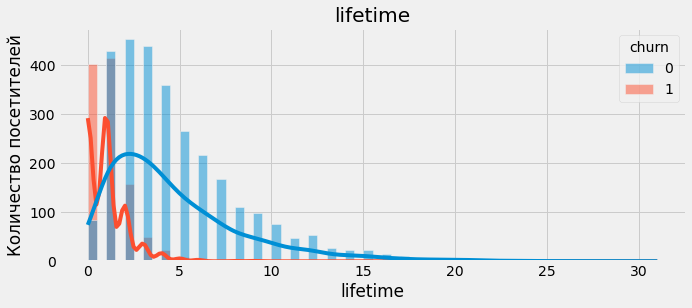

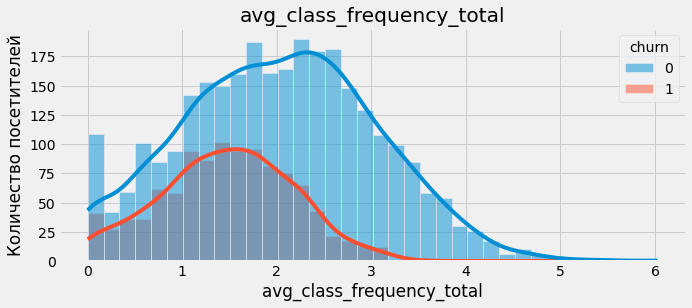

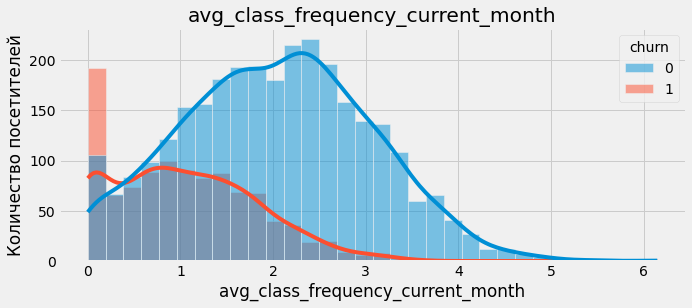

In [13]:
# построим столбчатые гистограммы для количественных признаков
for col in gym_churn.drop(['churn', 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits'], 
                          axis = 1).columns:
    plt.figure(figsize=(10,4))
    sns.histplot(data=gym_churn, x=col, hue="churn", kde=True)
    plt.title(col)
    plt.ylabel('Количество посетителей')
    plt.show(); 

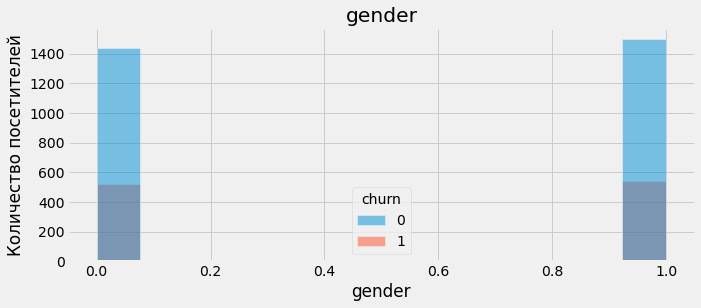

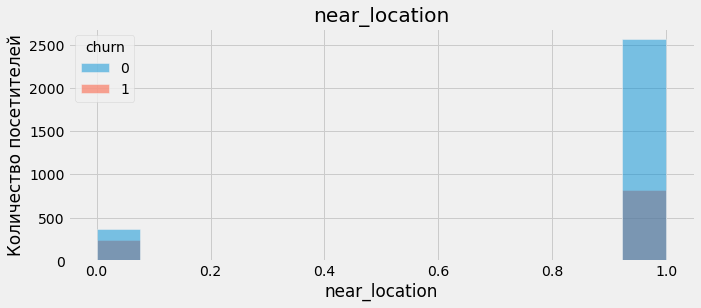

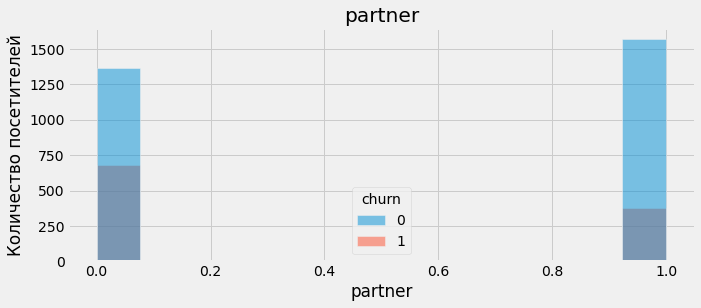

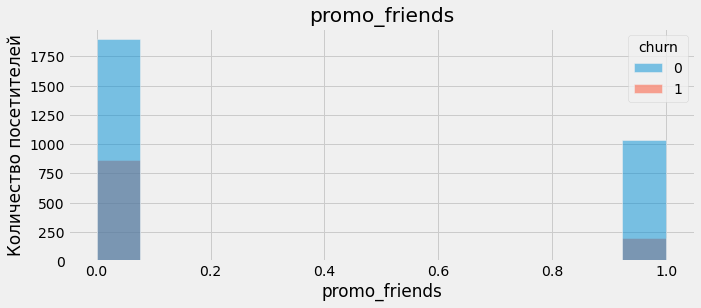

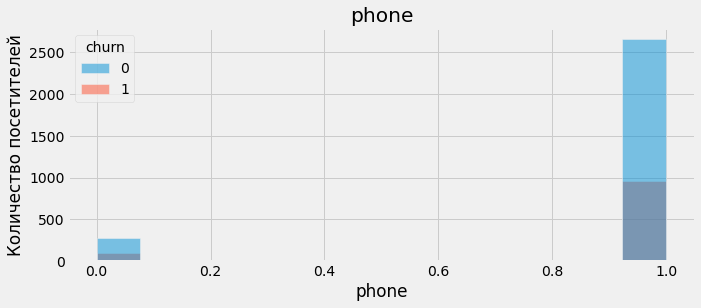

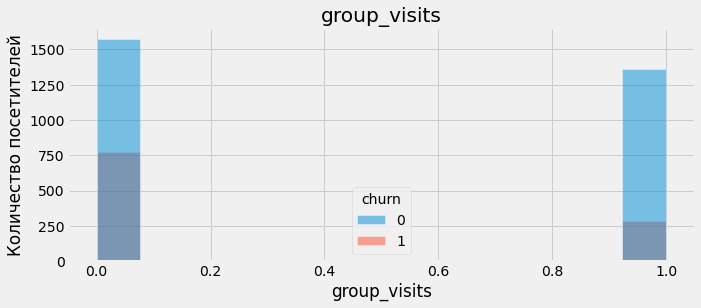

In [14]:
# построим столбчатые гистограммы для категориальных признаков
for col in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    plt.figure(figsize=(10,4))
    sns.histplot(data=gym_churn, x=col, hue="churn")
    plt.title(col)
    plt.ylabel('Количество посетителей')
    plt.show(); 

Исходя из полученных результатов можно сказать, что:

- распределение по гендерному признаку равное;
- рядом живущие или работающие клиенты реже уходят;
- сотрудник компании-партнёра клуба редко уходит;
- клиент, который использовал промо-код от знакомого при оплате первого абонемента гораздо реже уходят;
- наличие номера телефона не удерживает клиента в членах клуба;
- посещение групповых занятий помогает удержанию;
- клиенты с коротким сроком контракта чаще уходят;
- ушедшие клиенты моложе оставшихся;
- выручку на дополнительных услугах делают оставшиеся клиенты;
- почти все клиенты попавшие в отток имели месяц до истечения срока действующего абонемента;
- чаще всего покидают клуб на первом и втором месяце занятий;
- у оставшихся клиентов выше посещаемость и в неделю и в месяц.

## Построим корреляционную матрицу и нарисуем на её основе heatmap.

In [15]:
mc_gym_churn = gym_churn.corr() # посчитаем матрицу корреляции

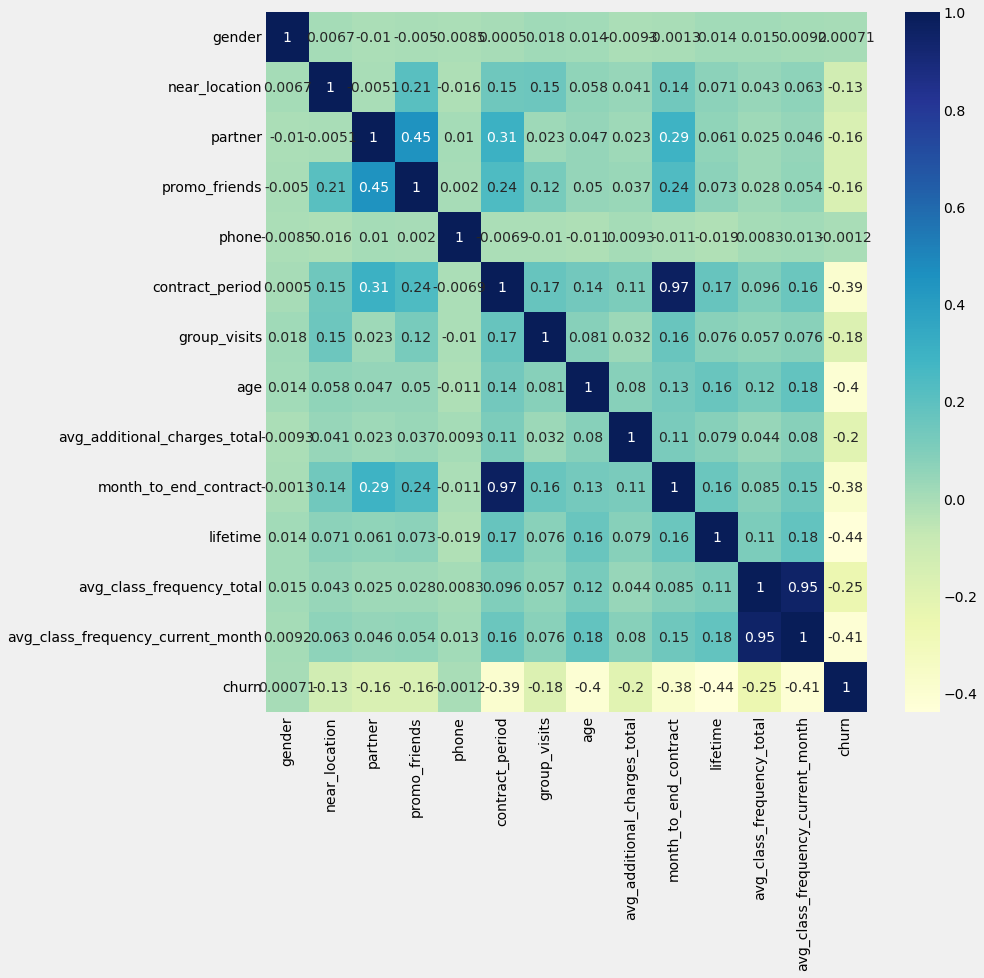

In [16]:
plt.figure(figsize=(12,12))
sns.heatmap(data=mc_gym_churn, annot=True, cmap='YlGnBu'); # построим тепловую карту

Изучив график, можно сказать, что сильной корреляции между целевой переменной ('churn') и остальными признаками нет. Но всё же в большей степени 'churn' коррелирует с 'lifetime' (-0.49), 'contract_period' (-0.39), 'month_to_end_contract' (-0.38) и 
'age'(-0.36).

Есть две пары признаков, которые хорошо кореллируют друг с другом:
- 'contract_period' и 'month_to_end_contract'
- 'avg_class_frequency_total' и 'avg_class_frequency_current_month'
Оставим все признакаи как есть, т.к. в логистической регрессии автоматически стоит регуляризация l2, а случайный лес не подвержен влиянию мультиколлинеарности.

***Вывод***

Клиет вероятнее всего останет членом клуба, если он:

- пришёл из компании партнёра, 
- живёт или работает рядом с клубом,
- использовал промо-код от знакомого при оплате первого абонемента,
- купил абонемент больше чем на месяц, 
- посещает групповые занятия,
- пользуется дополнительными услугами (кафе, спорттовары, косметический и массажный салон),
- посещает клуб несколько раз в неделю.

# Построение модели прогнозирования оттока клиентов.

***Задача*** 
Построить модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [17]:
# разделим данные на признаки и целевую переменную
X = gym_churn.drop('churn', axis=1)
y = gym_churn['churn']

In [18]:
# разобъём данные на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Обучим модель на train-выборке логистической регрессией. LogisticRegression

In [19]:
model_log = LogisticRegression(solver='liblinear') # задаём алгоритм логистической регрессии
model_log.fit(X_train, y_train) # обучим модель 

LogisticRegression(solver='liblinear')

In [20]:
predictions_log = model_log.predict(X_test) # сделаем прогноз
probabilities = model_log.predict_proba(X_test)[:,1] # оценка вероятности, что churn 1

In [21]:
acc_log = accuracy_score(y_test, predictions_log) # посчитаем метрику accuracy (долю правильных ответов)

# посчитаем метрики precision (очность ответов) и recall (полнота) 
precision_log = precision_score(y_test, predictions_log)
recall_log = recall_score(y_test, predictions_log)

In [22]:
display('Метрики для модели LogisticRegression по всем исходным признакам.')
display('Accuracy: {:.2f}'.format(acc_log))
display('Precision: {:.2f}'.format(precision_log))
display('Recall: {:.2f}'.format(recall_log))

'Метрики для модели LogisticRegression по всем исходным признакам.'

'Accuracy: 0.93'

'Precision: 0.86'

'Recall: 0.83'

## Обучим модель на train-выборке случайным лесом. RandomForestClassifier

In [23]:
# зададим алгоритм и обучим модель
rf_model = RandomForestClassifier(n_estimators = 50, random_state = 0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=0)

In [24]:
rf_predictions = rf_model.predict(X_test)# сделаем прогнозы
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

In [25]:
rf_acc = accuracy_score(y_test, rf_predictions) # посчитаем метрику accuracy (долю правильных ответов)

# посчитаем метрики precision (очность ответов) и recall (полнота) 
rf_precision = precision_score(y_test,rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)

In [26]:
display('Метрики для модели RandomForestClassifier по всем исходным признакам.')
display('Accuracy: {:.2f}'.format(rf_acc))
display('Precision: {:.2f}'.format(rf_precision))
display('Recall: {:.2f}'.format(rf_recall))

'Метрики для модели RandomForestClassifier по всем исходным признакам.'

'Accuracy: 0.92'

'Precision: 0.84'

'Recall: 0.82'

Обучив модели двумя разными алгоритмами и сравнив метрики, можно сказать, что метод логистической регрессии дал чуть более высокие показатели. При этом обе модели показали высокое количество правильных ответов - больше 90%. 

Логистическая регрессия показала точность ответов (метрика Precision) выше на две сотых, а полнота (метрика Recall) на одну сотую.

# Сделаем кластеризацию клиентов.

## Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

In [27]:
# стандартизируем данные
scaler = StandardScaler()
X_sс = scaler.fit_transform(X) 

linked = linkage(X_sс, method = 'ward') # создаём матрицу расстояний  

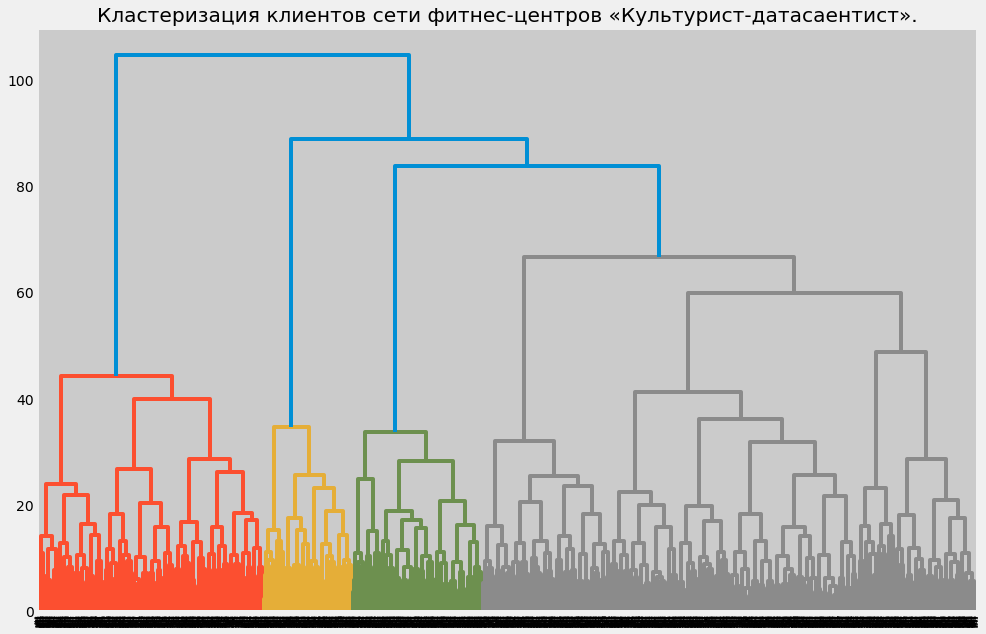

In [28]:
# рисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов сети фитнес-центров «Культурист-датасаентист».')
plt.show();

На основании полученного графика, можно предположить, что оптимально выделить четыре кластера. 

## Спрогнозируем кластеры клиентов обучив модель кластеризации на основании алгоритма K-Means.

In [29]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров = 5(условие задания)
labels = km.fit_predict(X_sс) # прогнозируем кластеры
gym_churn['cluster_km'] = labels # дабавим в df метки кластеров

In [30]:
gym_churn.groupby(by='cluster_km').mean() # сгруппируем по кластерам и посмотрим на средние значения признаков

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Кластер 0

- минимальный отток - 2%
- живут или работают рядом с фитнес-центром
- сотрудники компаний-партнёров - 78%
- пришли в рамках акции "приведи друга" - 57%
- длительность текущего действующего абонемента - 10.9 месяца
- больше половины посещают групповые программы
- lifetime - 4.7 месяца

Кластер 1

- отток - 27%
- живут или работают не далеко с фитнес-центром
- сотрудники компаний-партнёров - 47%
- пришли в рамках акции "приведи друга" - 30%
- длительность текущего действующего абонемента - 4.8 месяца
- чуть меньше половины посещают групповые программы
- lifetime - 3.9 месяца

Кластер 2

- отток - 44%
- живут или работают далеко с фитнес-центром
- сотрудники компаний-партнёров - 46%
- пришли в рамках акции "приведи друга" - 8%
- длительность текущего действующего абонемента - 2.3 месяца
- посещают групповые программы около 21%
- lifetime - 2.8 месяца

Кластер 3 

- отток - 51%
- живут или работают рядом с фитнес-центром
- сотрудники компаний-партнёров - 35%
- пришли в рамках акции "приведи друга" - 24%
- длительность текущего действующего абонемента - 2 месяца
- посещают групповые программы около 34%
- lifetime - 2.44 месяца

Кластер 4

- отток - 7%
- живут или работают рядом с фитнес-центром
- сотрудники компаний-партнёров - 35%
- пришли в рамках акции "приведи друга" - 23%
- длительность текущего действующего абонемента - 2.7 месяца
- посещают групповые программы около 47%
- lifetime - 4.9 месяца

Лучшими по показателю оттока оказались кластеры 0 и 4. Туда вошли посетители, которые живут или работают радом с фитнес-центром, около половины из них посещает групповые занятия, имеет lifetime больше 4.5 месяцев, многие для первоначальной записи воспользовались акцией "приведи друга", больше остальных заплатили за дополнительные услуги, посещают центр 2-3 раза в неделю. 

## Построим распределения признаков для кластеров.

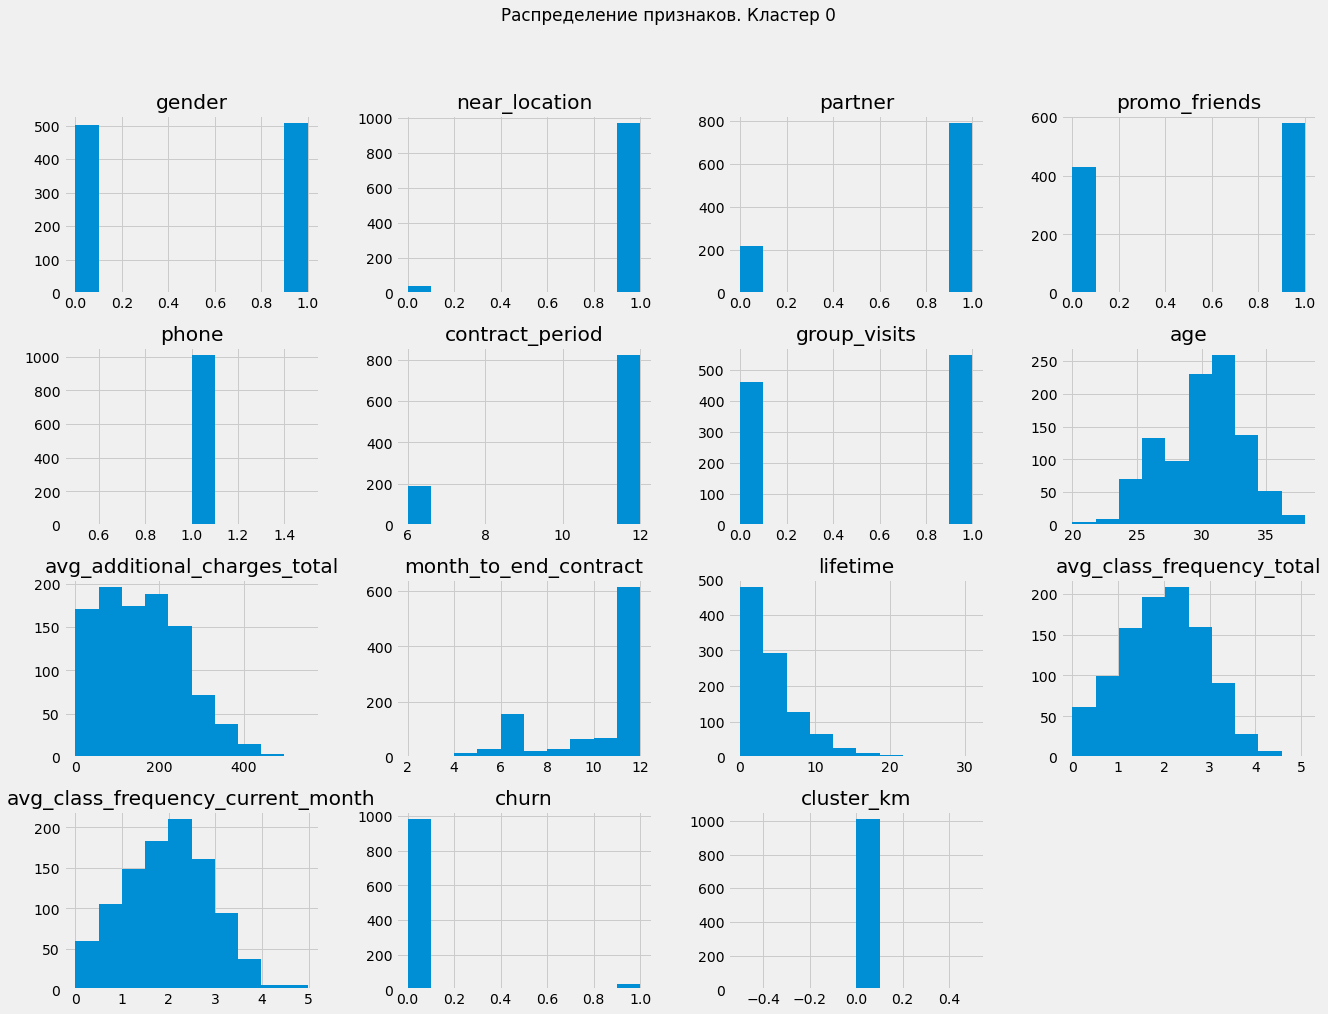

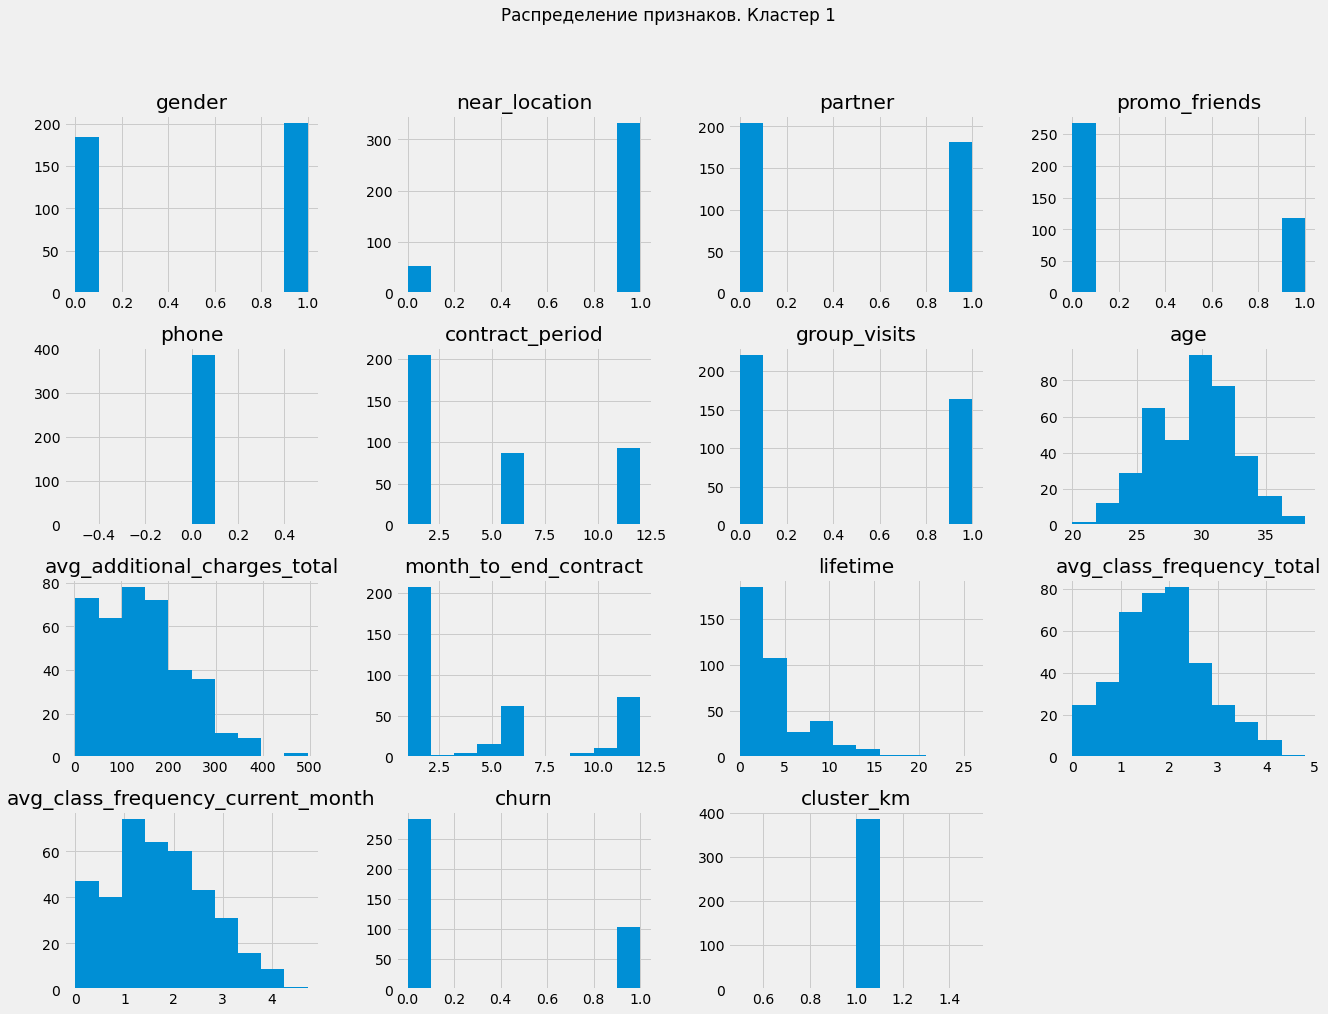

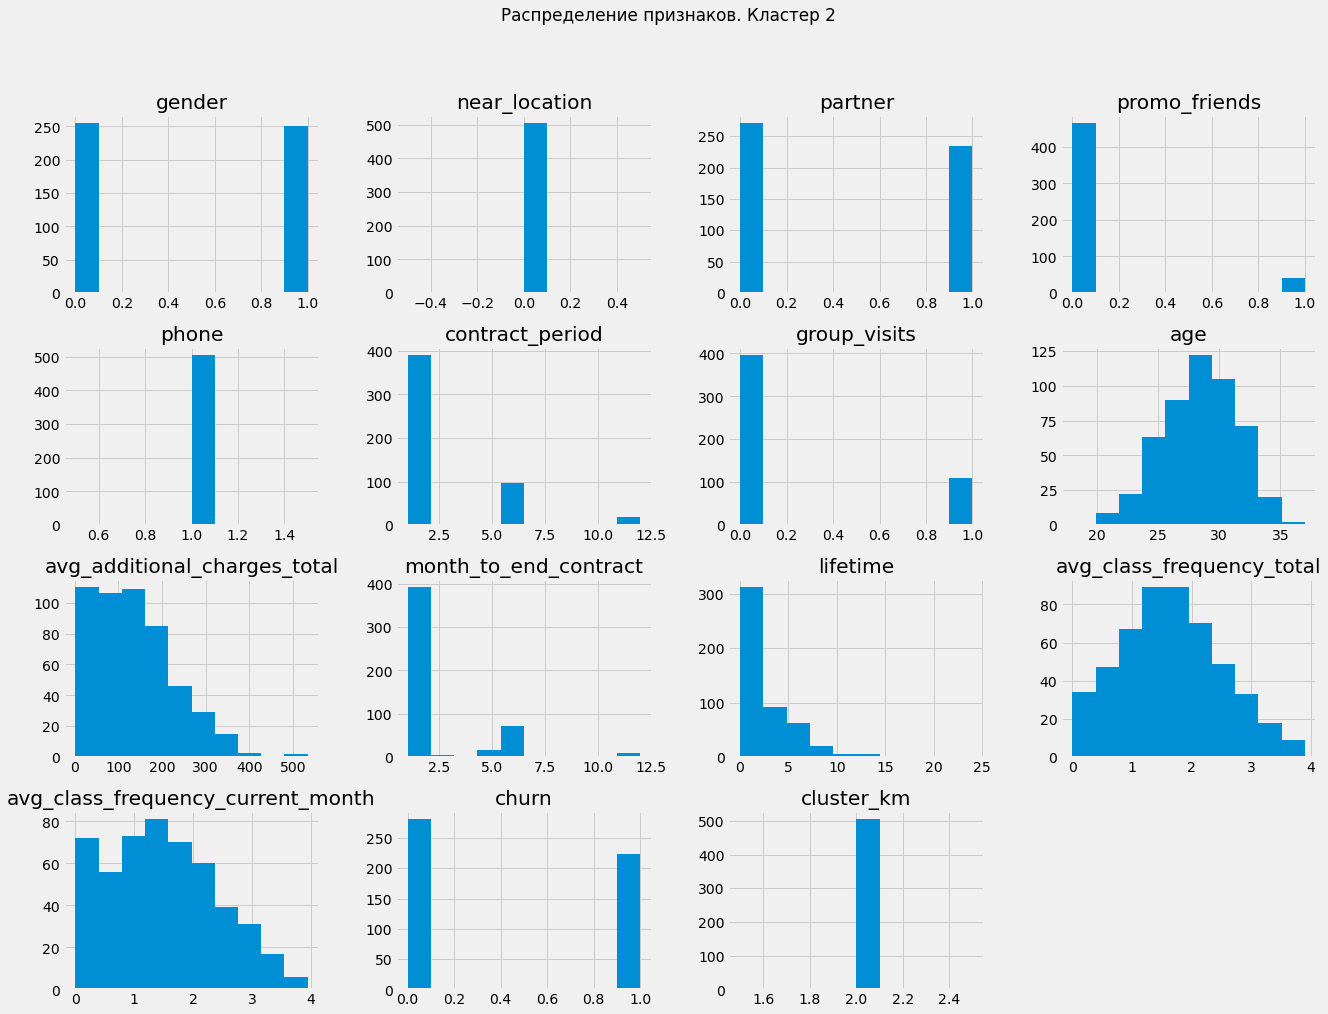

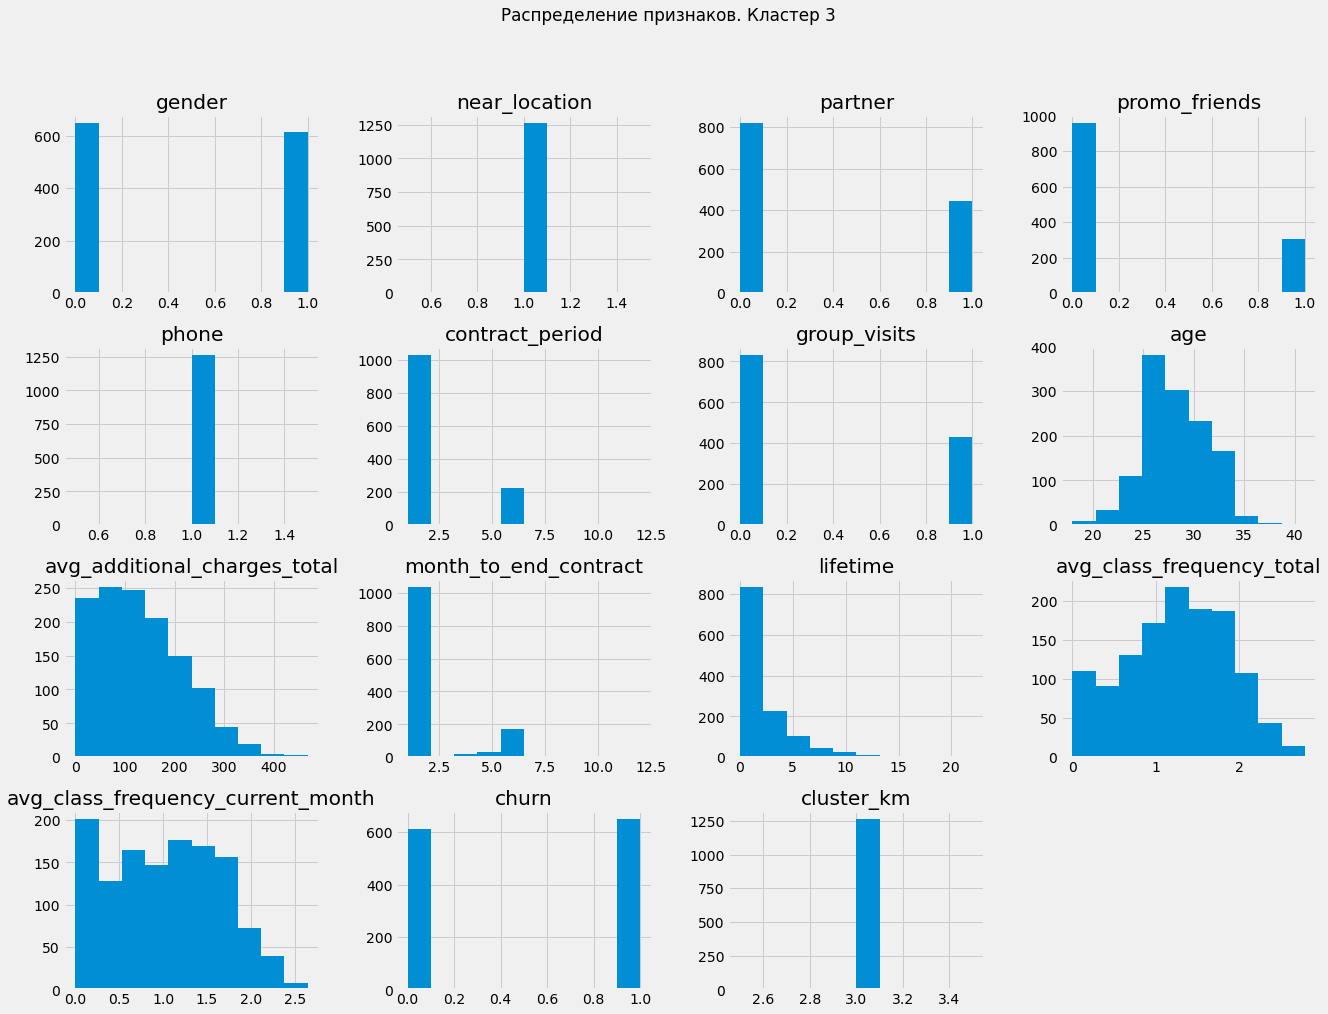

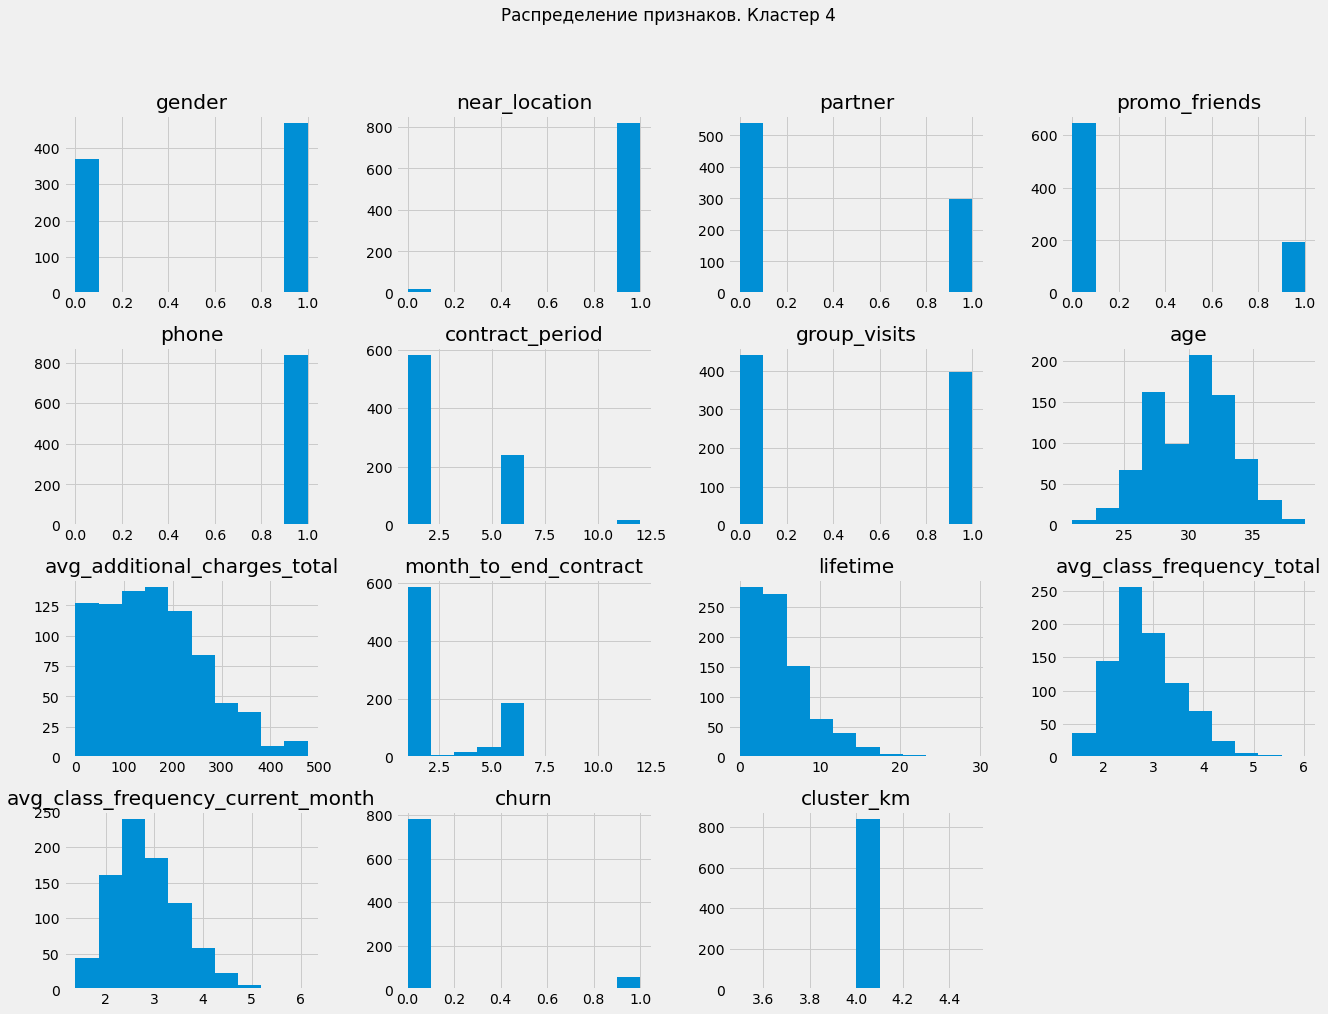

In [31]:
for values in gym_churn['cluster_km'].sort_values().unique():
    (gym_churn.loc[lambda gym_churn: gym_churn['cluster_km'] == values]).hist(figsize=(20,15))
    plt.suptitle('Распределение признаков. Кластер {}'.format(values))
    plt.show();

Самый высокий процент оттока среди клиентов попавших в кластер 3. 

Для большинства из них характерно:

- не являются сотрудниками компаний-партнёров
- не использовали промо-код от знакомого при оплате первого абонемента
- оплачиват абонемент на месяц
- не посещают групповые занятия
- за всё время пользования услугами центра посещали его не чаще двух раз в неделю

# Выводы и рекомендации по работе с клиентами.

Рассмотрев исходные данные в совокупности можно сказать:

- распределение по гендерному признаку равное;
- рядом живущие или работающие клиенты реже уходят;
- сотрудник компании-партнёра клуба редко уходит;
- клиент, который использовал промо-код от знакомого при оплате первого абонемента гораздо реже уходят;
- наличие номера телефона не удерживает клиента в членах клуба;
- посещение групповых занятий помогает удержанию;
- клиенты с коротким сроком контракта чаще уходят;
- ушедшие клиенты моложе оставшихся;
- выручку на дополнительных услугах делают оставшиеся клиенты;
- почти все клиенты попавшие в отток имели месяц до истечения срока действующего абонемента;
- чаще всего покидают клуб на первом и втором месяце занятий;
- у оставшихся клиентов выше посещаемость и в неделю и в месяц.

В ходе исследования предоставленных данных, было построено две модели двумя разными алгоритмами. При этом обе модели показали высокое количество правильных ответов. Это даёт возможность прогнозировать верояность оттока для каждого клиента.

Выявить один конкретный признак влияющий на отток обнаружено не было.

Разбив клиентов на 5 кластеров с помощию алгоритма K-Means. 
Можно выделить:
- кластер 0, как самых надёжных клиентов с оттоком 2%
- кластер 4 , весьма надёжных клиентов с оттоком 7%
- кластер 3 , самые не надёжные клиенты с оттоком 51%

Главное отличие этих кластеров в среднем значении метрик:
- 'partner', 
- 'promo_friends',
- 'contract_period',
- 'group_visits'
- 'avg_class_frequency_total'

Исходя из всего выше изложенного можно рекомендовать:

- развивать программы по привлечению сотрудников компаний-партнёров
- усилить работу в клубе с постоянными клиентами для привлечения их друзей и родных (совместные походы в зал дисциплинирут)
- использовать социальные сети или другие средства коммуникации для привлечения клиентов на групповые занятия. Возможно стоит их разнообрать организацией соревнований, совместных выездов в парки, за город...)

Всё это достаточно очевидно. Возможно есть ещё какие-то важные признаки, которые мы не учли в исследовании(например, нет разбивки по центрам и мы не видим по какому из них больший отток; время открытия центра и не понятно это давно существующее место или оно недавно появилось). Для более детального исследования и качественных рекомендаций нужно больше данных.